<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/main/Demos/Ch6_MatrixMultiplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Multiplication

1. Writing our own code and comparing to `numpy`
2. Level-3 BLAS vs repeated level-2 BLAS calls
3. Blocking/caching

There are interesting further resources on this MIT 18.335 numerical analysis class website, taught by Steven Johnson (developer of [FFTW](https://en.wikipedia.org/wiki/FFTW))
- [Main class website and syllabus](https://github.com/mitmath/18335#lecture-11-feb-26)
- [PDF on speed of matrix multiplies](https://github.com/mitmath/18335/blob/master/notes/matmuls.pdf)
- [Interactive Jupyter notebook, in Julia, doing matrix multiplies](https://github.com/mitmath/18335/blob/master/notes/Memory-and-Matrices.ipynb)

We'll talk about a few things like
- [BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms), such as Intel's [MKL](https://en.wikipedia.org/wiki/Math_Kernel_Library). BLAS is used by Matlab, Mathematica, Python (Numpy), R and Julia
- [LAPACK](https://en.wikipedia.org/wiki/LAPACK), used by Matlab, Python (Scipy), and Julia
   - There are newer linear algebra libraries that are useful in some contexts, such as [EIGEN](http://eigen.tuxfamily.org/index.php?title=FAQ) for C++, [libFLAME](https://www.cs.utexas.edu/~flame/web/libFLAME.html), [CUDA libraries](https://docs.nvidia.com/cuda-libraries/index.html) for the GPU including [MAGMA](https://developer.nvidia.com/magma) and others listed at the [CUDA-X "Parter Libraries](https://developer.nvidia.com/gpu-accelerated-libraries) (scroll down)
- Python can be accelerated a few ways, including:
  1. [PyPy](https://en.wikipedia.org/wiki/PyPy) which has a [just-in-time-compiler](https://en.wikipedia.org/wiki/Just-in-time_compilation)
  2. [Cython](https://en.wikipedia.org/wiki/Cython)
  3. [Numba](https://numba.pydata.org/)

In [1]:
import numpy as np
rng = np.random.default_rng()
from timeit import timeit, time
import matplotlib.pyplot as plt

Check which [BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) numpy is using

In [2]:
np.show_config()

Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: /opt/_internal/cpython-3.12.2/lib/python3.12/site-packages/scipy_openblas64/include
    lib directory: /opt/_internal/cpython-3.12.2/lib/python3.12/site-packages/scipy_openblas64/lib
    name: scipy-openblas
    openblas configuration: OpenBLAS 0.3.27  USE64BITINT DYNAMIC_ARCH NO_AFFINITY
      Zen MAX_THREADS=64
    pc file directory: /project/.openblas
    version: 0.3.27
  lapack:
    detection method: pkgconfig
    found: true
    include directory: /opt/_internal/cpython-3.12.2/lib/python3.12/site-packages/scipy_openblas64/include
    lib directory: /opt/_internal/cpython-3.12.2/lib/python3.12/site-packages/scipy_openblas64/lib
    name: scipy-openblas
    openblas configuration: OpenBLAS 0.3.27  USE64BITINT DYNAMIC_ARCH NO_AFFINITY
      Zen MAX_THREADS=64
    pc file directory: /project/.openblas
    version: 0.3.27
Compilers:
  c:
    commands: cc
    linker: ld.bfd
    name: gcc


Check how many [cores](https://en.wikipedia.org/wiki/Multi-core_processor) are available to us, and how many we are using.  Most BLAS is multithreaded and will take advantage of extra cores (we use "[multithreading](https://en.wikipedia.org/wiki/Multithreading_(computer_architecture))" to talk about [parallelism](https://en.wikipedia.org/wiki/Parallel_computing) on a single CPU usually with a [shared memory](https://en.wikipedia.org/wiki/Shared_memory), in contrast to other types of parallel computing that run on several differenct computers, e.g., on a [cluster](https://en.wikipedia.org/wiki/Computer_cluster))

On colab, we only have 2 cores (perhaps 1 real core, using [hyperthreading](https://en.wikipedia.org/wiki/Hyper-threading) to appear as 2 cores?) because Google is giving the computation away for free, so they don't give us too much.  On your own computer, expect to see a number like 4, 8, 16 or 32 (for a desktop).

So if we really wanted to, we could tell `numpy` to only use 1 core, to make it a more fair comparison with our own Python implementations which will not be multithreaded

In [3]:
# Simplified from https://stackoverflow.com/a/29582987
import ctypes
import contextlib
def set_num_threads(n):
    """Set the current number of threads used by the OpenBLAS server."""
    openblas_lib.openblas_set_num_threads(int(n))
def get_num_threads():
    """Get the current number of threads used by the OpenBLAS server."""
    return openblas_lib.openblas_get_num_threads()
@contextlib.contextmanager
def num_threads(n):
  """Temporarily changes the number of OpenBLAS threads.
  Use like
  with num_threads(1):
    np.dot(x, y)
  """
  set_num_threads(n)

openblas_lib = ctypes.cdll.LoadLibrary('libopenblas.so.0')
print("We have",openblas_lib.openblas_get_num_procs(),"cores available")

We have 2 cores available


## Writing our own matrix multiply
**Never** do this.  It's super slow, as we'll see why

This [MIT 18.335 Memory-and-Matrices](https://github.com/mitmath/18335/blob/master/notes/Memory-and-Matrices.ipynb) jupyter notebook (using Julia, not Python) gives a good discussion of some issues (caching and [cache-oblivious algorithms](https://en.wikipedia.org/wiki/Cache-oblivious_algorithm), multithreading, [vector instructions](https://en.wikipedia.org/wiki/Vector_processor) like [AVX](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions), [unrolling](https://en.wikipedia.org/wiki/Loop_unrolling), etc.)

Note: if you had some code that you couldn't call from a library and had to write your own version, and speed was really important, there are several options you can try, including:
1. Try [PyPy](https://en.wikipedia.org/wiki/PyPy) which has a [just-in-time-compiler](https://en.wikipedia.org/wiki/Just-in-time_compilation)
2. Try [Cython](https://en.wikipedia.org/wiki/Cython)
3. Try [Numba](https://numba.pydata.org/)
4. [Call C or C++ from within Python](https://docs.python.org/3/extending/extending.html).  In Matlab, you do this with a [mex](https://www.mathworks.com/help/matlab/call-mex-file-functions.html) file

In [4]:
def matrix_multiply(A,B,algorithm=1):
  m,q = A.shape
  p,n = B.shape
  if q != p:
    raise ValueError('the matrices must have matching inner dimension')
  C = np.zeros((m,n))
  if algorithm == 1:
    for i in range(m):
      a = A[i,:] # We can try to give suggestions to make it faster, but unlikely to change much if done in pure Python
      for j in range(n):
        for k in range(q):
          #C[i,j] += A[i,k]*B[k,j]
          C[i,j] += a[k]*B[k,j]
  elif algorithm == 2:
    for j in range(n):
      for i in range(m):
        for k in range(q):
          C[i,j] += A[i,k]*B[k,j]
  elif algorithm == 3:
    for i in range(m):
      for k in range(q):
        for j in range(n):
          C[i,j] += A[i,k]*B[k,j]
  # There are other ways to do it too...
  return C

def my_dot_product(a,b):
  c = 0.
  for i in range(len(a)):
    c += a[i]*b[i]
  return c

#### See if we get the right answer
Start with a small problem

In [5]:
seed = 12345
rng = np.random.default_rng(seed) # reproducible
# rng = default_rng() # gives us new random numbers ever time
n = 4
A = rng.standard_normal((n,n))
B = rng.standard_normal((n,n))
with np.printoptions(precision=3):
  print("A is")
  print(A)

A is
[[-1.424  1.264 -0.871 -0.259]
 [-0.075 -0.741 -1.368  0.649]
 [ 0.361 -1.953  2.347  0.968]
 [-0.759  0.902 -0.467 -0.061]]


In [6]:
C = matrix_multiply(A,B,algorithm=1)
with np.printoptions(precision=3):
    print("Our answer is:")
    print(C)
    print("And true answer is:")
    print(A@B)
print(f"i.e., norm(error) is {np.linalg.norm(C-A@B):.3e}")

Our answer is:
[[ 0.239  0.341  1.289 -4.185]
 [ 0.296  1.401  1.63   1.745]
 [-0.998  3.722 -3.956  4.283]
 [ 0.563  0.315  0.958 -2.538]]
And true answer is:
[[ 0.239  0.341  1.289 -4.185]
 [ 0.296  1.401  1.63   1.745]
 [-0.998  3.722 -3.956  4.283]
 [ 0.563  0.315  0.958 -2.538]]
i.e., norm(error) is 2.618e-16


#### Now try some timing


In [7]:
n = 350
A = rng.standard_normal((n,n))
B = rng.standard_normal((n,n))

start_time = time.time()
%time C = matrix_multiply(A,B,algorithm=1)
myTime = time.time() - start_time

%time C = matrix_multiply(A,B,algorithm=2)
# %time C = matrix_multiply(A,B,algorithm=3)

start_time = time.time()
%time C = A@B
numpyTime = time.time() - start_time

print(f'My code took {myTime:.4f} sec, numpy took {numpyTime:.4f} sec, so it was {myTime/numpyTime:.1f} faster')

CPU times: user 30.1 s, sys: 24.1 ms, total: 30.2 s
Wall time: 30.7 s
CPU times: user 30 s, sys: 27 ms, total: 30 s
Wall time: 30.8 s
CPU times: user 5.83 ms, sys: 989 µs, total: 6.82 ms
Wall time: 3.61 ms
My code took 30.6954 sec, numpy took 0.0042 sec, so it was 7370.8 faster


Let's also see how slow our dot product is

In [8]:
# For level-1 operations, there's less of a performance loss
a = A.ravel()  # doesn't create new data (unlike flatten)
b = B.ravel()
start_time = time.time()
%time c1 = my_dot_product(a,b)
myTime = time.time() - start_time
start_time = time.time()
%time c2 = np.dot(a,b)
numpyTime = time.time() - start_time
print("Discrepancy is", c1-c2 )
print(f'My code took {myTime:.4f} sec, numpy took {numpyTime:.4f} sec, so it was {myTime/numpyTime:.1f} faster')

CPU times: user 46 ms, sys: 998 µs, total: 47 ms
Wall time: 46.8 ms
CPU times: user 693 µs, sys: 3 µs, total: 696 µs
Wall time: 443 µs
Discrepancy is 4.490630090003833e-12
My code took 0.0475 sec, numpy took 0.0010 sec, so it was 48.1 faster


The performance loss for our dot product (Level-1 BLAS) wasn't as bad (only 15x to 30x slower) compared to for a matrix multiply (Level-3 BLAS) (2,000x to 3,000x slower)

### .. but of course a Python multiply is slow
Everyone knows Python and Matlab (and interpreted languages) are not fast with `for` loops.

Let's make it more fair: let's do an implementation in C, and try a larger matrix

In [11]:
n = 1000
A = rng.standard_normal((n,n))
B = rng.standard_normal((n,n))

%time C = A@B
# Note: we have 2 threads, so wall time is about 1/2 of total time
# (the first line reports the sum of times in all processors)

CPU times: user 130 ms, sys: 984 µs, total: 131 ms
Wall time: 80.2 ms


Our C implementation (note: we hardcode the size at $n=1000$ for simplicity)

We're also not taking the matrices as inputs, we're just multiplying whatever bytes happen to be in them when we ask for the memory

In [14]:
C_program = """
#include <stdlib.h>
#include <stdio.h>
#include <time.h>
int main() {
    int M, N, P, i, j, k;
    double *A, *B, *C;
    double c;
    clock_t t;
    N   = 1000;
    M   = N;
    P   = N;
    A   = (double *)calloc(M*P,sizeof(double));
    B   = (double *)calloc(P*N,sizeof(double));
    C   = (double *)calloc(M*N,sizeof(double));
    /* initialize A and B */
    for (i=0;i<M;i++)
        for (j=0;j<P;j++)
            A[i+j*M] = i + j*M;
    for (i=0;i<P;i++)
        for (j=0;j<N;j++)
            B[i+j*P] = i + j*P;
    /* the multiply */
    t = clock();
    for (i=0;i<M;i++){
        for (j=0;j<N;j++){
            c = 0.0;
            for (k=0; k<P; k++)
                c += A[i+k*M] * B[k+j*P];
            C[i+j*M] = c;
        }
    }
    t = clock() - t;
    printf("Time take is %.5f seconds\\n", ((double)t)/CLOCKS_PER_SEC );
    /* If we don't do something with C, then eager compiler will decide we
     * don't even need to calculate it, and code won't do anything! */
    printf("First entry in C is %.2f\\n", C[0] );
    return 0;
}
"""

Save this to a file:

In [16]:
# %store C_program > matMult.c
with open('matMult.c', 'w') as f:
    f.write(C_program)
#  run !cat matMult.c   to see if it worked

Compile the code using the `gcc` compiler, which is available on the colab virtual computer

In [17]:
!gcc -O3 matMult.c -o matMult.out

Run the code (note: in the C code, we are using the somewhat crude `clock` function, but we have to do something since we don't want to include the time for making the matrices)

In [18]:
!./matMult.out

Time take is 3.20199 seconds
First entry in C is 332833500000.00


It's still slow!!

## Level-3 vs Level-2 BLAS

We'll multiply two 2000 x 2000 matrices, first as just a single level-3 BLAS call:

In [21]:
n = 1000
A = rng.standard_normal((n,n))
B = rng.standard_normal((n,n))

start_time = time.time()
%time C = A@B
numpy_time = time.time() - start_time

CPU times: user 110 ms, sys: 0 ns, total: 110 ms
Wall time: 55.3 ms


We can also view it as loops:
$$A=\begin{bmatrix}-\,a_1^T\,-\\-\,a_2^T\,-\\-\,a_3^T\,-\end{bmatrix},\quad
B=\begin{bmatrix}|&|&|\\b_1&b_2&b_3\\|&|&|\end{bmatrix}
$$
so
$$AB = \begin{bmatrix}|&|&|\\Ab_1&Ab_2&Ab_3\\|&|&|\end{bmatrix}
$$
and
$$AB=\begin{bmatrix}-\,a_1^TB\,-\\-\,a_2^TB\,-\\-\,a_3^TB\,-\end{bmatrix}$$

In [27]:
CC = np.zeros((n,n))
# Loop over columns of the output C
start_time = time.time()
for i in range(n):
  CC[:,i] = A@B[:,i]
my_time1 = time.time() - start_time
np.linalg.norm(C-CC) # make sure we get the right answer

CC = np.zeros((n,n))
# Loop over rows of the output C
# (should be a bit faster since numpy uses row-major order)
start_time = time.time()
for i in range(n):
  CC[i,:] = A[i,:]@B
my_time2 = time.time() - start_time

# np.linalg.norm(C-CC) # make sure we get the right answer
print(f"Looping over columns, code took {my_time1:.3f} sec, so {my_time1/numpy_time:.1f} x slower")
print(f"Looping over rows,    code took {my_time2:.3f} sec, so {my_time2/numpy_time:.1f} x slower")

Looping over columns, code took 0.313 sec, so 5.6 x slower
Looping over rows,    code took 0.329 sec, so 5.9 x slower


## Speed vs size and caching
We can check that we see $O(n^3)$ speed complexity

However, the curve may not be that smooth due to caching issues, e.g., some sizes fit nicely into cache, others don't and so require more ache calls.  BLAS tries to be careful about this so we won't see such a difference.  Our own code isn't so careful so we might see a big difference, but... our code is so slow that it takes a long time and we can't test a wide variety of input sizes

In [28]:
reps = 5
nList = range(30,400)
timeList = []
for n in nList:
  A = rng.standard_normal((n,n))
  B = rng.standard_normal((n,n))
  start_time = time.time()
  for r in range(reps):
    C = A@B
  myTime = time.time() - start_time
  timeList.append( myTime/reps )

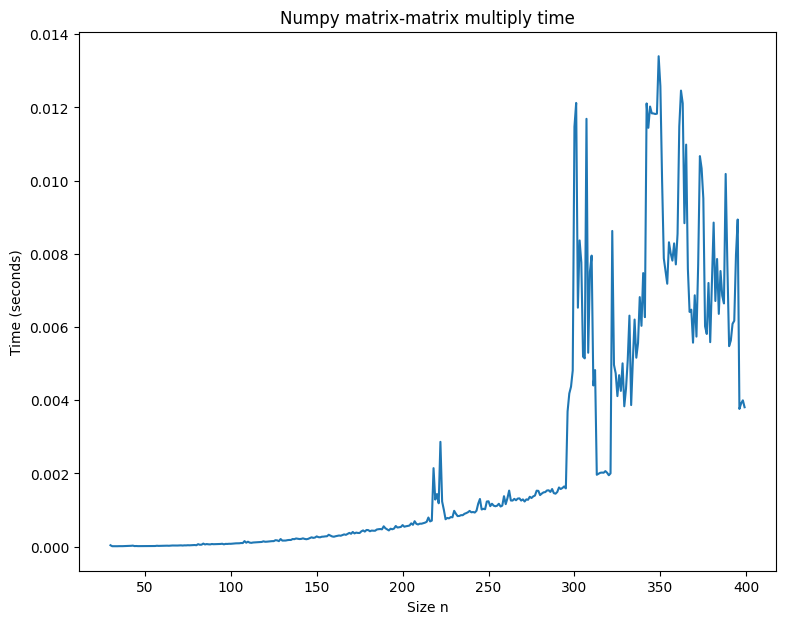

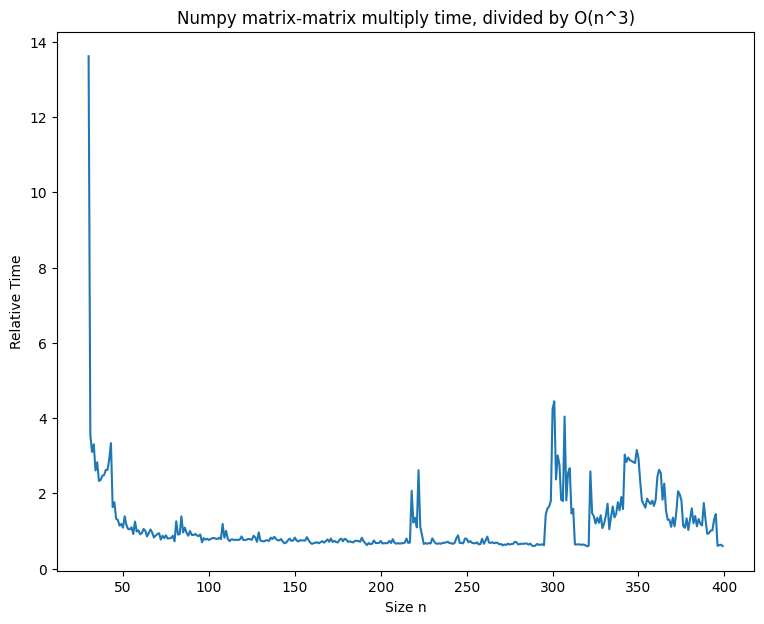

In [29]:
plt.figure(figsize=(9,7))
plt.plot( nList, timeList )
plt.xlabel('Size n')
plt.ylabel('Time (seconds)')
plt.title('Numpy matrix-matrix multiply time')
plt.show()

timeList = np.asarray(timeList)
nList = np.asarray(nList)
plt.figure(figsize=(9,7))
plt.plot( nList, timeList/(1e-10*nList**3) )
plt.xlabel('Size n')
plt.ylabel('Relative Time')
plt.title('Numpy matrix-matrix multiply time, divided by O(n^3)')
plt.show()

Same thing but larger $n$

In [30]:
reps = 2 # average things out (reduce to 1 if impatient)
nList = np.logspace(1,3.6,12)
timeList = []
for n in nList:
  n = int(n)
  A = rng.standard_normal((n,n))
  B = rng.standard_normal((n,n))
  start_time = time.time()
  for r in range(reps):
    C = A@B # using numpy/BLAS
  myTime = time.time() - start_time
  timeList.append( myTime/reps )

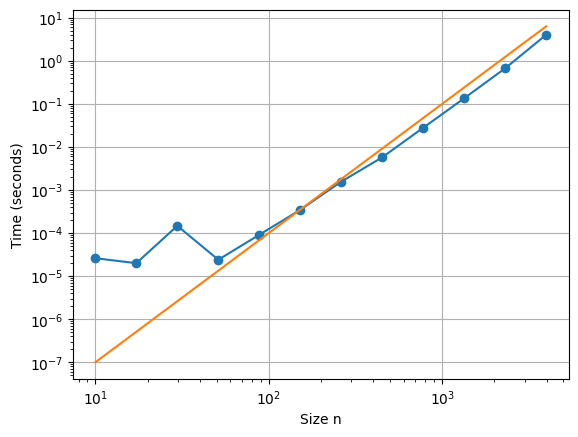

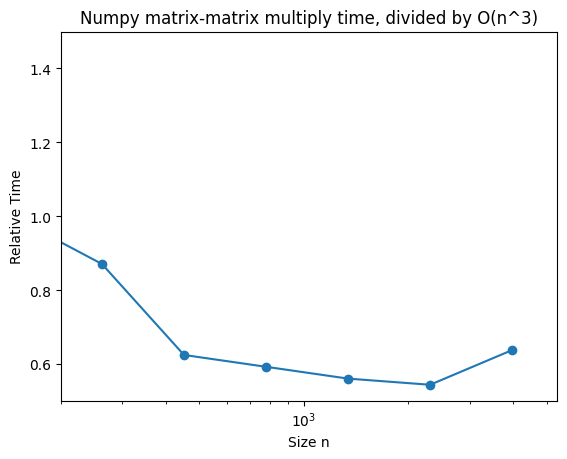

In [32]:
plt.loglog( nList,timeList, 'o-' )
plt.loglog( nList, 1e-10*np.array(nList)**3)
plt.xlabel('Size n')
plt.ylabel('Time (seconds)')
plt.grid()
plt.show()

timeList = np.asarray(timeList)
nList = np.asarray(nList)
plt.semilogx( nList, timeList/(1e-10*nList**3),'o-' )
plt.xlabel('Size n')
plt.ylabel('Relative Time')
plt.title('Numpy matrix-matrix multiply time, divided by O(n^3)')
plt.xlim(left=200)
plt.ylim(top=1.5,bottom=.5)
plt.show()

And try with our own implementation. Effect should be greater, but our code is so slow that we can't do this for many different values

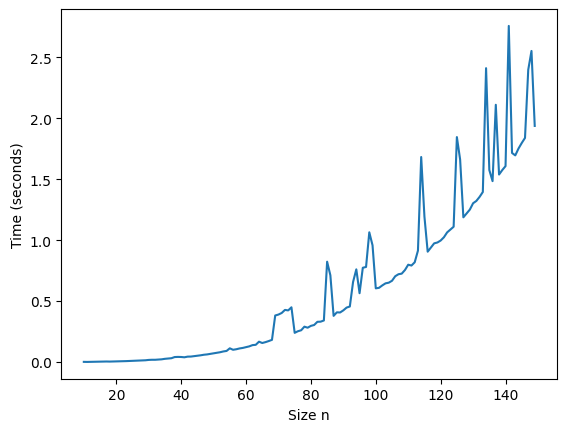

In [33]:
reps = 1
nList = range(10,150, 1)
timeList = []
for n in nList:
  A = rng.standard_normal((n,n))
  B = rng.standard_normal((n,n))
  start_time = time.time()
  for r in range(reps):
    C = matrix_multiply(A,B)
    #C = A@B
  myTime = time.time() - start_time
  timeList.append( myTime/reps )

plt.plot( nList, timeList )
plt.xlabel('Size n')
plt.ylabel('Time (seconds)')
plt.show()

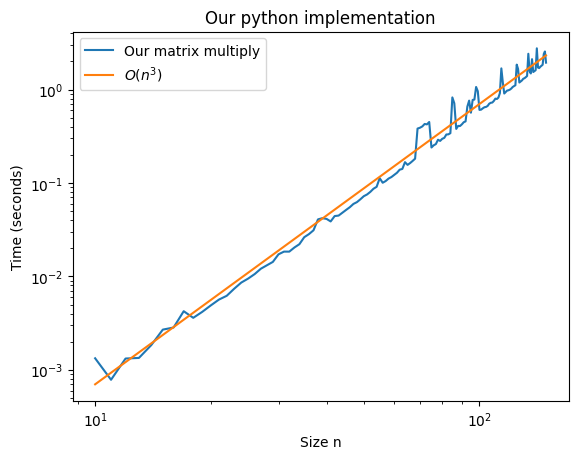

In [34]:
plt.loglog( nList, timeList,label='Our matrix multiply' )
plt.loglog( nList, 7e-7*np.array(nList)**3,label="$O(n^3)$")
plt.xlabel('Size n')
plt.ylabel('Time (seconds)')
plt.title('Our python implementation')
plt.legend()
plt.show()